In [1]:
# importing packages
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest
from CP2LFI.scores import LambdaScore
from clover import Scores
from clover import LocartSplit
from copy import deepcopy
from tqdm import tqdm
from scipy import stats
from scipy.optimize import minimize_scalar
import time
import itertools

description of the experiment

In [2]:
# simulator
def sim_gamma(n,gamma_shape, gamma_scale, X=None):
    normal_mean = gamma_shape*gamma_scale
    normal_std = np.sqrt(gamma_shape)*gamma_scale 
    
    random_x = X if X is not None else np.random.uniform(0, 1, n)
    diff = list()

    for x in random_x:
        q_gamma = stats.gamma.ppf(x, a=gamma_shape, scale=gamma_scale)
        q_normal = stats.norm.ppf(x, normal_mean, normal_std)
        diff.append(abs(q_gamma - q_normal))

    if n == 1:
        return diff[0]
    return diff


# randomly sampling from gamma
def sample_gamma(n, N, thetas, seed=1000):
    #np.random.seed(seed)
    
    lambdas = np.zeros(n)
    i = 0
    for (shape, scale) in thetas:
        lambdas[i] = sim_gamma(1, shape, scale)
        i += 1
    return lambdas


# naive method
def naive(alpha, B=1000, N=100, seed=250, naive_n=100):
    np.random.seed(seed)
    n_grid = int(B / naive_n)

    grid = np.linspace((50, 2), (90, 5), n_grid)
    
    quantiles = {}
    for params in tqdm(grid,  desc="Obtaining naive quantiles"):
        shape = params[0]
        scale = params[1]
        X_stat = sim_gamma(N, shape, scale)
        quantiles[(shape, scale)] = np.quantile(X_stat, q=1 - alpha)
    return quantiles


# naive predict function
def predict_naive_quantile(theta_grid, quantiles_dict):
    lambda_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for x in theta_grid:
        distances = np.linalg.norm(lambda_values - x, axis=1)
        idx = lambda_values[np.argmin(distances)]
        quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list

In [3]:
def evaluate_coverage(quantiles_dict, thetas, alpha=0.05, n=500, N=100):
    err_data = np.zeros((thetas.shape[0], 4))
    coverage_data = np.zeros((thetas.shape[0], 4))
    j = 0
    for theta in tqdm(thetas, desc="Computing coverage for each method"):
        # generating several lambdas
        stat = np.zeros(n)
        for i in range(0, n):
            stat[i] = sample_gamma(n = 1, N = N, thetas=theta.reshape(-1, 2))
        # comparing coverage of methods
        locart_cover = np.mean(stat <= quantiles_dict["locart"][j])
        loforest_cover = np.mean(stat <= quantiles_dict["loforest"][j])
        boosting_cover = np.mean(stat <= quantiles_dict["boosting"][j])
        naive_cover = np.mean(stat <= quantiles_dict["naive"][j])

        # appending the errors
        err_locart = np.abs(locart_cover - (1 - alpha))
        err_loforest = np.abs(loforest_cover - (1 - alpha))
        err_boosting = np.abs(boosting_cover - (1 - alpha))
        err_naive = np.abs(naive_cover - (1 - alpha))

        # saving in numpy array
        err_data[j, :] = np.array([err_locart, err_loforest, err_boosting, err_naive])
        coverage_data[j, :] = np.array(
            [locart_cover, loforest_cover, boosting_cover, naive_cover]
        )
        j += 1

    # obtaining MAE and standard error for each method
    mae_vector, std_vector = np.mean(err_data, axis=0), np.std(err_data, axis=0)
    stats_data = pd.DataFrame(
        {
            "methods": ["LOCART", "LOFOREST", "boosting", "naive"],
            "MAE": mae_vector,
            "str": std_vector / (np.sqrt(thetas.shape[0])),
        }
    )

    coverage_data = pd.DataFrame(
        {
            "thetas": [str(tuple(row)) for row in thetas],
            "LOCART": coverage_data[:, 0],
            "LOFOREST": coverage_data[:, 1],
            "boosting": coverage_data[:, 2],
            "naive": coverage_data[:, 3],
        }
    )
    return [stats_data, coverage_data]

In [4]:
N, B, alpha = 100, 1000, 0.05

In [5]:
N, B, alpha = 100, 1000, 0.05

start_time = time.time()
naive_quantiles = naive(alpha, B = B, N = N)
end_time = time.time()

running_time = end_time - start_time
print(f"Naive running time: {running_time} seconds.")

Obtaining naive quantiles: 100%|██████████████████████████| 10/10 [00:00<00:00, 131.63it/s]

Naive running time: 0.09588503837585449 seconds.


In [9]:
grid = np.linspace((50, 2), (150, 8), B)
model_lambdas = sample_gamma(n = B, N = N, thetas = grid, seed = 45)
model_thetas = grid.reshape(-1, 2)

In [10]:
start_time = time.time()
locart_object = LocartSplit(LambdaScore, None, alpha = alpha, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 100)
end_time = time.time()
print(f"LOCART running time: {end_time - start_time} seconds.")

# loforest quantiles
start_time = time.time()
loforest_object = ConformalLoforest(LambdaScore, None, alpha = alpha, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 300)
end_time = time.time()
print(f"LOFOREST running time: {end_time - start_time} seconds.")

# boosting quantiles
start_time = time.time()
model = HistGradientBoostingRegressor(loss="quantile", max_iter = 1000,
quantile = 1 - alpha, random_state = 105, n_iter_no_change = 20, early_stopping = True)
model.fit(model_thetas, model_lambdas)
end_time = time.time()
print(f"Boosting running time: {end_time - start_time} seconds.")

LOCART running time: 0.017998933792114258 seconds.
LOFOREST running time: 0.08802413940429688 seconds.
Boosting running time: 0.16219806671142578 seconds.


In [14]:
# naive quantiles
naive_list = predict_naive_quantile(grid, naive_quantiles)

# locart quantiles
idxs = locart_object.cart.apply(grid.reshape(-1, 2))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

# loforest
loforest_cutoffs = loforest_object.compute_cutoffs(grid.reshape(-1, 2))

# boosting
boosting_quantiles = model.predict(grid.reshape(-1, 2))

# dictionary of quantiles
quantile_dict = {
    "naive": naive_list,
    "locart": list_locart_quantiles,
    "loforest": loforest_cutoffs,
    "boosting": boosting_quantiles,
}

In [16]:
cover_data = evaluate_coverage(quantile_dict, grid, n = 1000)

Computing coverage for each method:   0%|                         | 0/1000 [00:00<?, ?it/s]/var/folders/4c/6zndblvs3slbw1n6pypvjv4h0000gn/T/ipykernel_32097/1677055931.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stat[i] = sample_gamma(n = 1, N = N, thetas=theta.reshape(-1, 2))
Computing coverage for each method: 100%|██████████████| 1000/1000 [01:06<00:00, 14.97it/s]


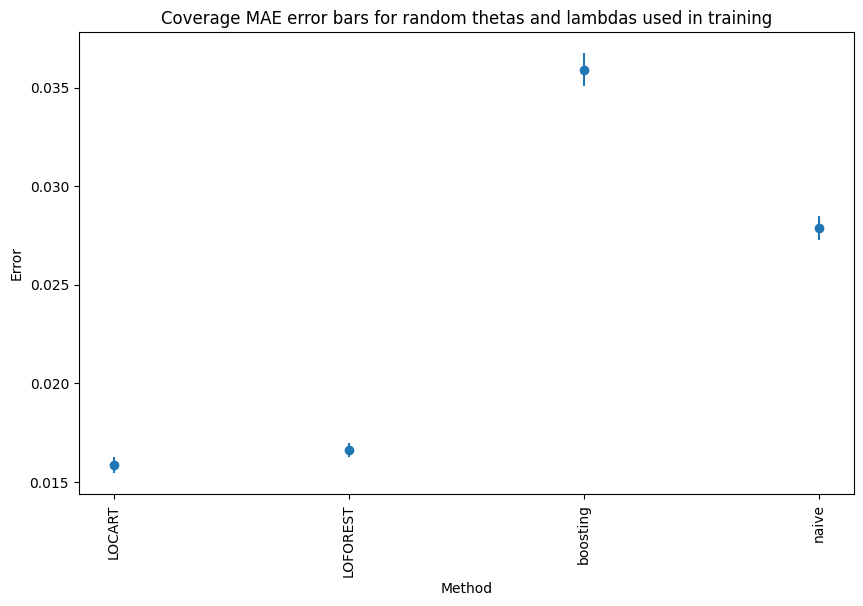

In [17]:
#| echo: false
keys = cover_data[0].iloc[:, 0].values
mae = cover_data[0].iloc[:, 1].values
std_err = cover_data[0].iloc[:, 2].values

plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars for random thetas and lambdas used in training')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

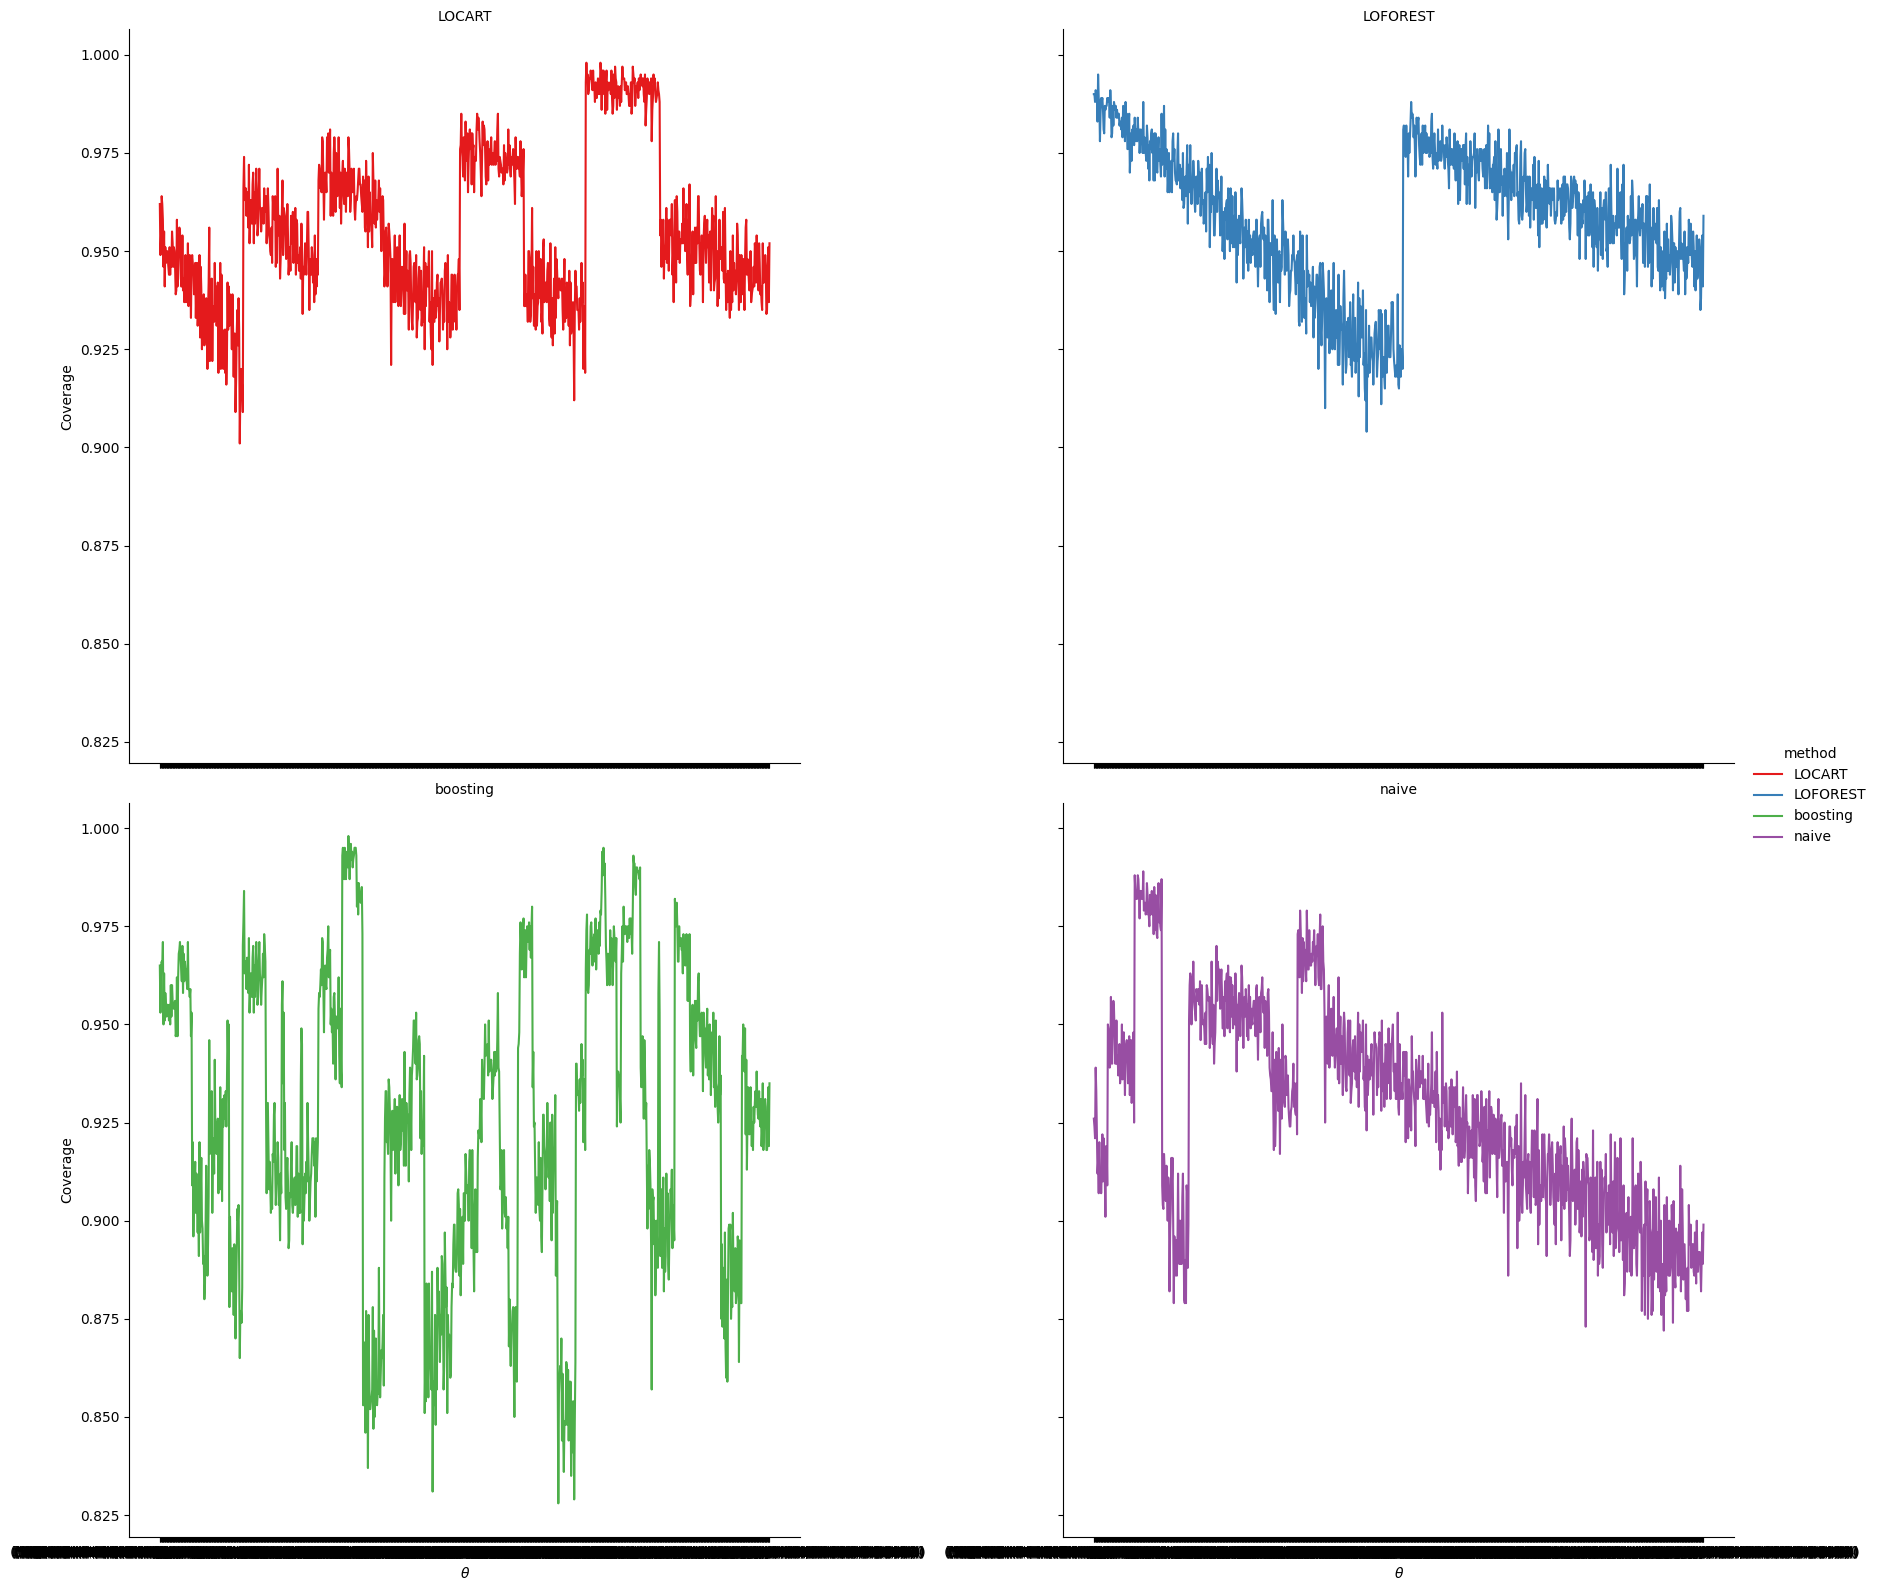

In [19]:
#| echo: false
# Melt the coverage data
coverage_data_melted = pd.melt(
    cover_data[1], id_vars=["thetas"], var_name="method", value_name="coverage")
# Plot the coverage as function of the thetas generated
g = sns.FacetGrid(coverage_data_melted, col="method", hue = "method",
 col_wrap = 2, height=8, aspect=1.10, palette = "Set1")
g.map(sns.lineplot, "thetas", "coverage")
g.add_legend()
g.set_titles("{col_name}")
g.set_xlabels(r"$\theta$")
g.set_ylabels("Coverage")
plt.show()

In [44]:
# function to compute all quantiles in a theta grid
def obtain_quantiles(
    thetas, N, B=1000, alpha=0.05, naive_seed=45, min_samples_leaf=100, naive_n=500
):
    # fitting and predicting naive
    naive_quantiles = naive(alpha=alpha, B=B, N=N, naive_n=naive_n)
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # simulating to fit models
    model_lambdas = sample_gamma(n=B, thetas=thetas, N=N, seed=45)
    model_thetas = thetas.reshape(-1, 2)

    locart_object = LocartSplit(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    locart_quantiles = locart_object.calib(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf
    )

    # loforest quantiles
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    loforest_object.calibrate(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf
    )

    # boosting quantiles
    model = HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile=1 - alpha,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
    model.fit(model_thetas, model_lambdas)

    # naive quantiles
    naive_list = predict_naive_quantile(thetas, naive_quantiles)

    # locart quantiles
    idxs = locart_object.cart.apply(thetas.reshape(-1, 2))
    list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(thetas.reshape(-1, 2))

    # boosting
    boosting_quantiles = model.predict(thetas.reshape(-1, 2))

    # dictionary of quantiles
    quantile_dict = {
        "naive": naive_list,
        "locart": list_locart_quantiles,
        "loforest": loforest_cutoffs,
        "boosting": boosting_quantiles,
    }

    return quantile_dict


# evaluate coverage for several N's and B = 1000
def evaluate_coverage_N(
    thetas,
    N=np.array([10, 100, 1000]),
    B=1000,
    alpha=0.05,
    n=1000,
    seed=45,
    min_samples_leaf=100,
    naive_n=100,
):
    coverage_data = np.zeros((thetas.shape[0] * N.shape[0], 4))
    N_list = []
    N_list_cover = []
    methods_list = []
    np.random.seed(seed)
    seeds = np.random.choice(np.arange(0, 10**4, 1), N.shape[0], replace=False)
    k = 0
    j = 0
    for N_fixed in tqdm(N, desc="Computing coverage for each N"):
        # computing all quantiles for fixed N
        quantiles_dict = obtain_quantiles(
            thetas,
            N=N_fixed,
            B=B,
            alpha=alpha,
            naive_seed=seeds[k],
            min_samples_leaf=min_samples_leaf,
            naive_n=naive_n,
        )
        err_data = np.zeros((thetas.shape[0], 4))
        l = 0
        for theta in tqdm(thetas, desc="Computing coverage for each method"):
        # generating several lambdas
            stat = np.zeros(n)
            for i in range(0, n):
                stat[i] = sample_gamma(n = 1, N = N, thetas=theta.reshape(-1, 2))


            # comparing coverage of methods
            locart_cover = np.mean(stat <= quantiles_dict["locart"][l])
            loforest_cover = np.mean(stat <= quantiles_dict["loforest"][l])
            boosting_cover = np.mean(stat <= quantiles_dict["boosting"][l])
            naive_cover = np.mean(stat <= quantiles_dict["naive"][l])

            # appending the errors
            err_locart = np.abs(locart_cover - (1 - alpha))
            err_loforest = np.abs(loforest_cover - (1 - alpha))
            err_boosting = np.abs(boosting_cover - (1 - alpha))
            err_naive = np.abs(naive_cover - (1 - alpha))

            # saving in numpy array
            err_data[l, :] = np.array(
                [err_locart, err_loforest, err_boosting, err_naive]
            )

            coverage_data[j, :] = np.array(
                [locart_cover, loforest_cover, boosting_cover, naive_cover]
            )
            N_list_cover.append(N_fixed)

            j += 1
            l += 1
        methods_list.extend(["LOCART", "LOFOREST", "boosting", "naive"])
        if k == 0:
            mae_vector = np.mean(err_data, axis=0)
            std_vector = np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))
        else:
            mean = np.mean(err_data, axis=0)
            std = np.std(err_data, axis=0) / (np.sqrt(thetas.shape[0]))
            mae_vector, std_vector = np.concatenate((mae_vector, mean)), np.concatenate(
                (std_vector, std)
            )
        k += 1
        N_list.extend([N_fixed] * 4)

    # obtaining MAE and standard error for each method
    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "MAE": mae_vector,
            "se": std_vector,
        }
    )
    #return [str(tuple(row)) for row in thetas], N_list_cover, coverage_data[:, 0], coverage_data[:, 1], coverage_data[:, 2], coverage_data[:, 3],
    coverage_data = pd.DataFrame(
        {
            "thetas": [str(tuple(row)) for row in thetas]*N.shape[0],
            "N": N_list_cover,
            "LOCART": coverage_data[:, 0],
            "LOFOREST": coverage_data[:, 1],
            "boosting": coverage_data[:, 2],
            "naive": coverage_data[:, 3],
        }
    )
    return [stats_data, coverage_data]

In [48]:
B = 1000
thetas = np.linspace((50, 2), (150, 8), 1000)

coverage_data_N_1000 = evaluate_coverage_N(thetas, B = 1000, naive_n = 100, n = 1000)

Obtaining naive quantiles: 100%|██████████████████████████| 10/10 [00:00<00:00, 679.07it/s]

Computing coverage for each method:   0%|                         | 0/1000 [00:00<?, ?it/s]/var/folders/4c/6zndblvs3slbw1n6pypvjv4h0000gn/T/ipykernel_32097/1687547030.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stat[i] = sample_gamma(n = 1, N = N, thetas=theta.reshape(-1, 2))

Obtaining naive quantiles: 100%|██████████████████████████| 10/10 [00:00<00:00, 109.69it/s]

Computing coverage for each method:   0%|                         | 0/1000 [00:00<?, ?it/s]/var/folders/4c/6zndblvs3slbw1n6pypvjv4h0000gn/T/ipykernel_32097/1687547030.py:100: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfo

/var/folders/4c/6zndblvs3slbw1n6pypvjv4h0000gn/T/ipykernel_32097/2714050596.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=90)
/var/folders/4c/6zndblvs3slbw1n6pypvjv4h0000gn/T/ipykernel_32097/2714050596.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=90)
/var/folders/4c/6zndblvs3slbw1n6pypvjv4h0000gn/T/ipykernel_32097/2714050596.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(a.get_xticklabels(), rotation=90)


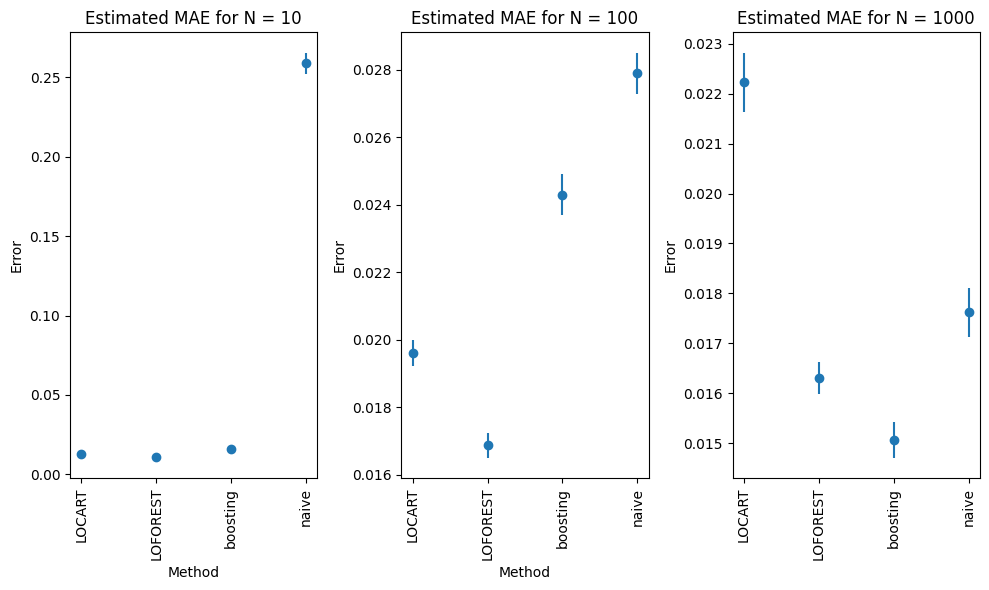

In [49]:
#| echo: false
fig, ax = plt.subplots(ncols=3, figsize=(10, 6))
# data for first subplot
data_10 = coverage_data_N_1000[0].query("N == 10")
keys = data_10.iloc[:, 0].values
mae = data_10.iloc[:, 2].values
std_err = data_10.iloc[:, 3].values
ax[0].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[0].set_xlabel("Method")
ax[0].set_ylabel("Error")
ax[0].set_title("Estimated MAE for N = 10")


data_100 = coverage_data_N_1000[0].query("N == 100")
keys = data_100.iloc[:, 0].values
mae = data_100.iloc[:, 2].values
std_err = data_100.iloc[:, 3].values
ax[1].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[1].set_xlabel("Method")
ax[1].set_ylabel("Error")
ax[1].set_title("Estimated MAE for N = 100")


data_1000 = coverage_data_N_1000[0].query("N == 1000")
keys = data_1000.iloc[:, 0].values
mae = data_1000.iloc[:, 2].values
std_err = data_1000.iloc[:, 3].values
ax[2].errorbar(keys, mae, yerr=std_err, fmt="o")
ax[2].set_ylabel("Error")
ax[2].set_title("Estimated MAE for N = 1000")

for a in ax:
    a.set_xticklabels(a.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

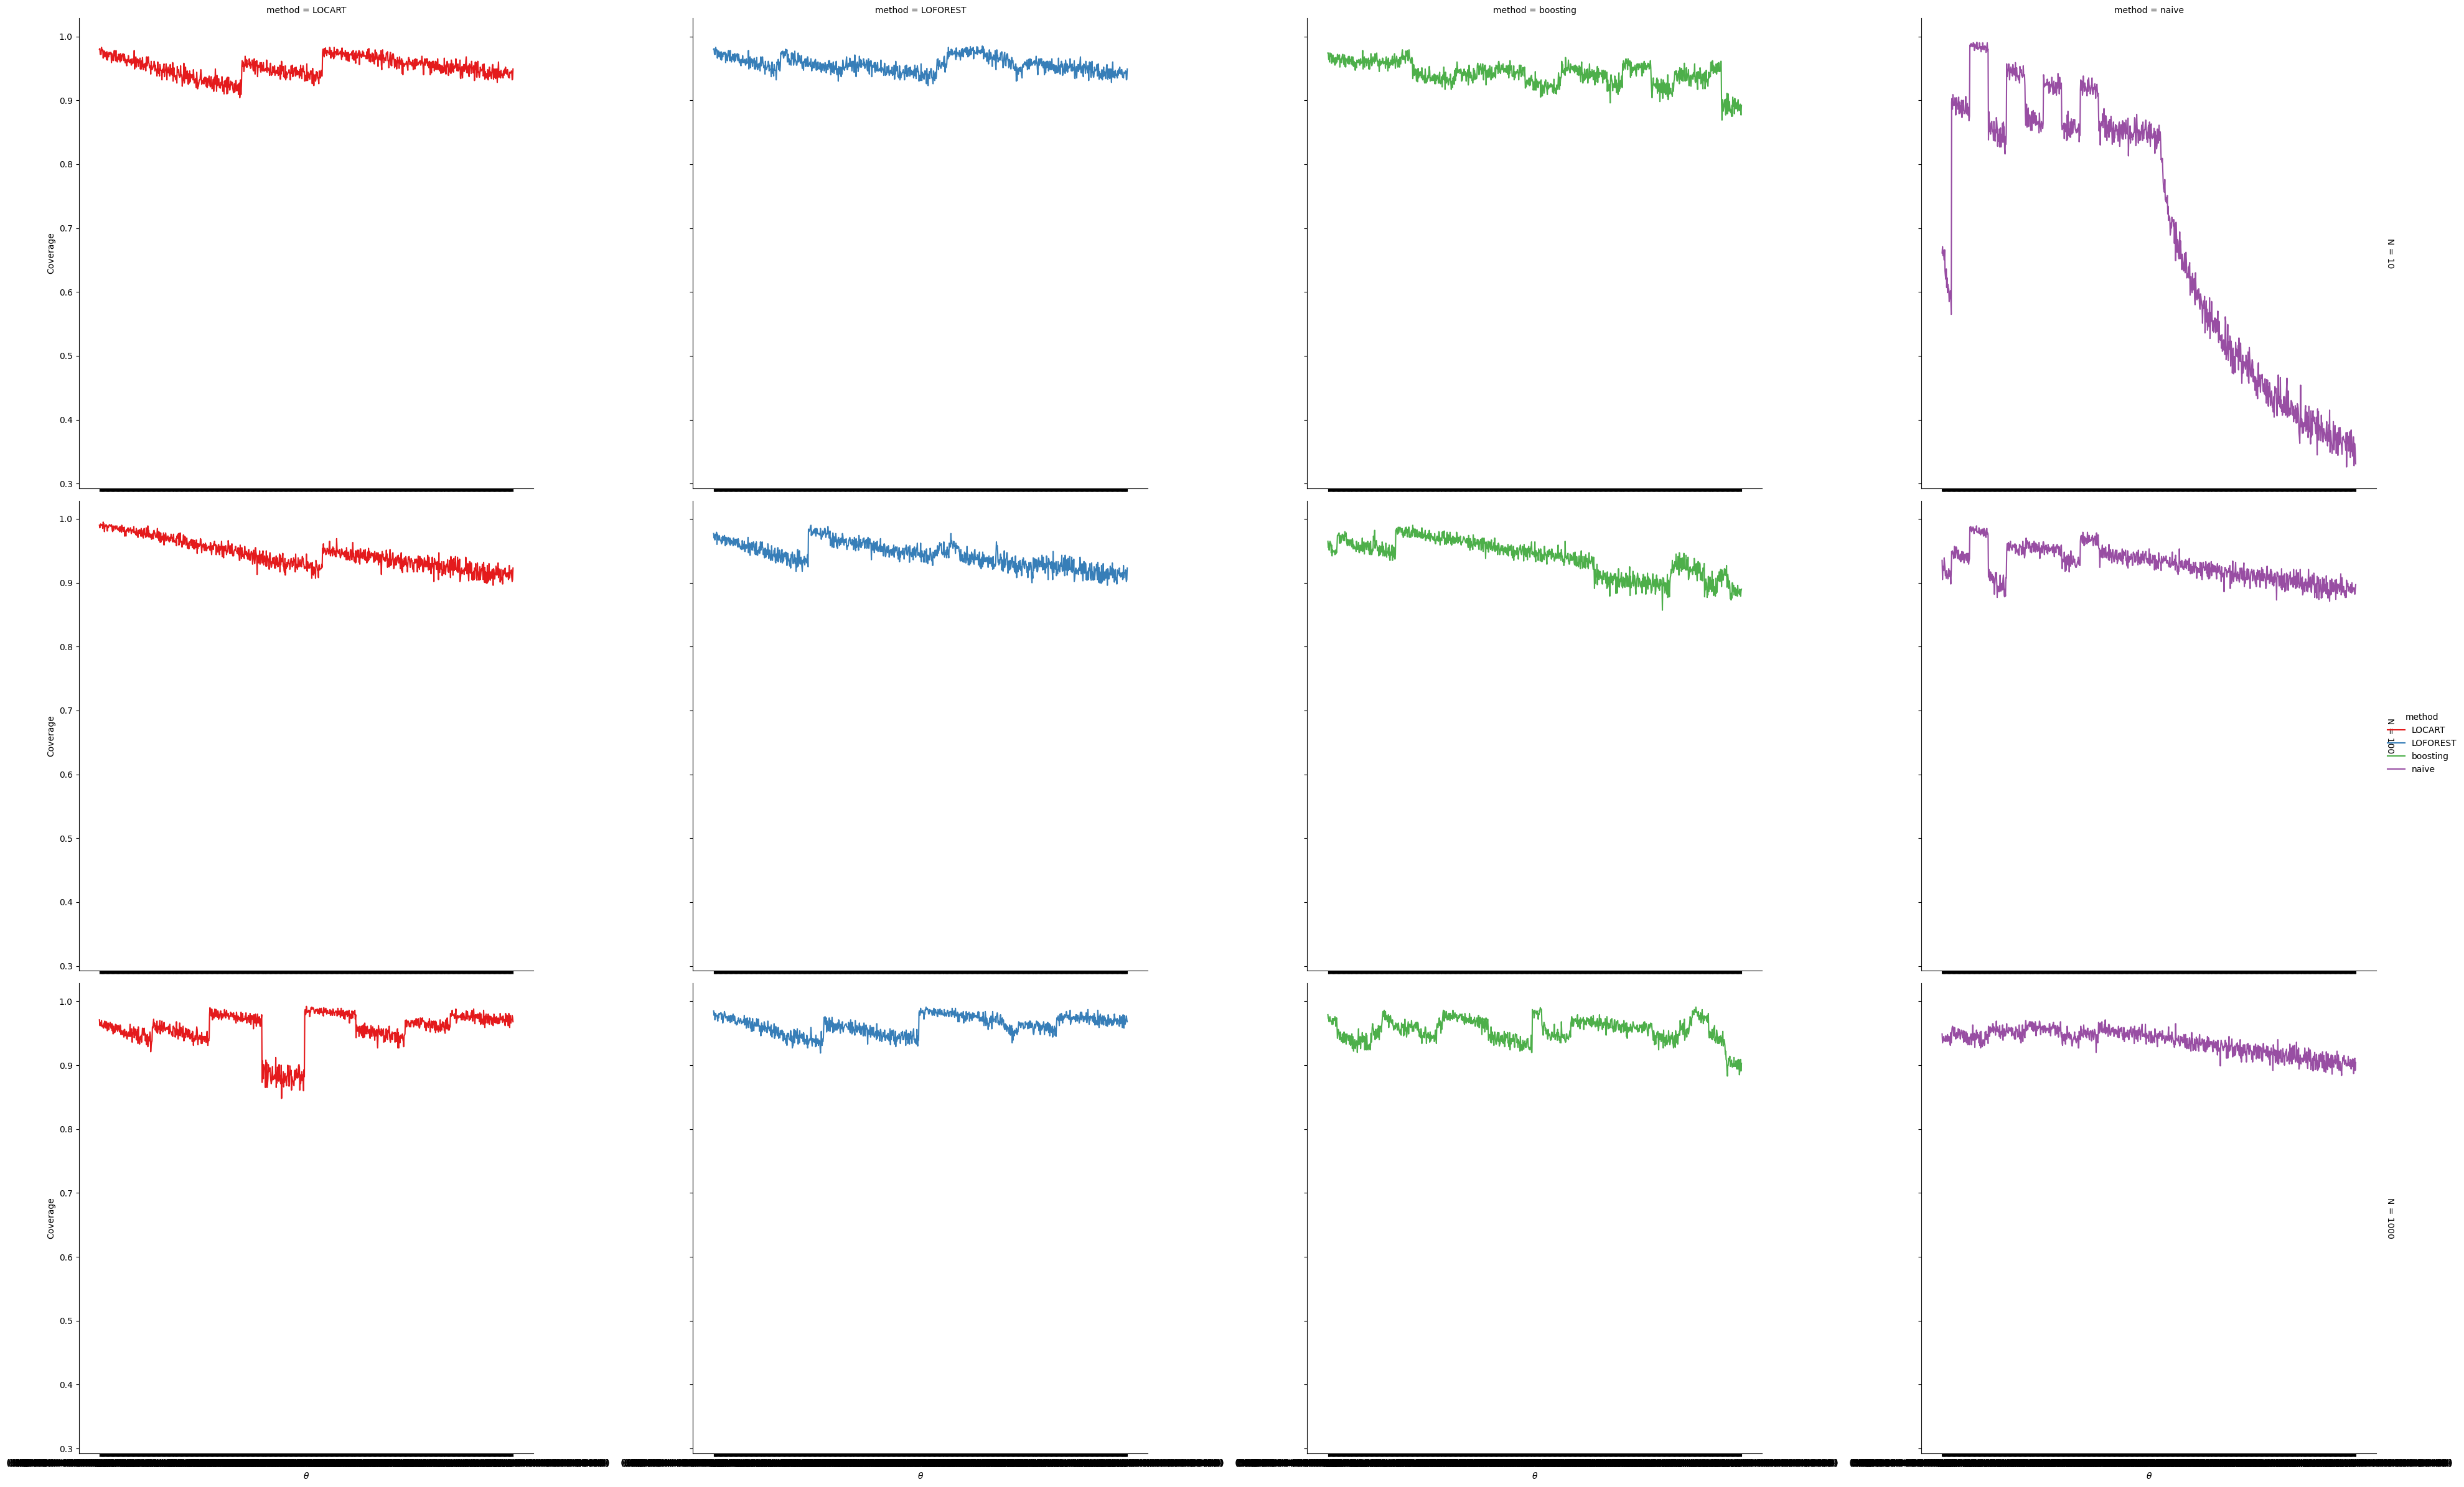

In [50]:
#| echo: false
# plotting coverage
coverage_data_melted = pd.melt(
    coverage_data_N_1000[1],
    id_vars=["thetas", "N"],
    var_name="method",
    value_name="coverage",
)
# Plot the coverage as function of the thetas generated
g = sns.FacetGrid(
    coverage_data_melted,
    row="N",
    col="method",
    hue="method",
    height= 8,
    aspect=1.20,
    palette="Set1",
    margin_titles = True
)
g.map(sns.lineplot, "thetas", "coverage")
g.add_legend()
g.set_titles("{col_name}")
g.set_xlabels(r"$\theta$")
g.set_ylabels("Coverage")
plt.tight_layout()
plt.show()

## new example

In [30]:
# simulator
def sim_gamma(gamma_shape, gamma_scale, n, threshold=None):

    normal_mean = gamma_shape*gamma_scale
    normal_std = np.sqrt(gamma_shape)*gamma_scale 
    
    random_x = np.random.gamma(gamma_shape, gamma_scale, n)

    if not threshold:
        threshold = np.random.choice(random_x)

    emp_prob = np.mean(random_x > threshold)
    norm_dist = np.random.normal(normal_mean, normal_std, n)
    t_prob = np.mean(norm_dist > threshold)

    lambda_stat = np.abs(t_prob - emp_prob)

    return lambda_stat

# randomly sampling from gamma
def sample_gamma(N, thetas, seed=1000):
    np.random.seed(seed)
    lambdas = np.zeros(N)
    i = 0
    for (shape, scale) in thetas:
        lambdas[i] = sim_gamma(gamma_shape=shape, gamma_scale=scale, n=N)
        i += 1
    return lambdas


# naive method
def naive(alpha, B=1000, N=100, seed=250, naive_n=100):
    np.random.seed(seed)
    n_grid = int(B / naive_n)

    grid = np.linspace((50, 2), (90, 5), n_grid)
    
    quantiles = {}
    for params in tqdm(grid,  desc="Obtaining naive quantiles"):
        shape = params[0]
        scale = params[1]
        X_stat = np.zeros(N)
        for i in range(N):
            X_stat[i] = sim_gamma(shape, scale, B)

        quantiles[(shape, scale)] = np.quantile(X_stat, q=1 - alpha)
    return quantiles


# naive predict function
def predict_naive_quantile(theta_grid, quantiles_dict):
    lambda_values = np.array(list(quantiles_dict.keys()))
    quantiles_list = []
    for x in theta_grid:
        distances = np.linalg.norm(lambda_values - x, axis=1)
        idx = lambda_values[np.argmin(distances)]
        quantiles_list.append(quantiles_dict[tuple(idx)])
    return quantiles_list

In [40]:
def evaluate_coverage(quantiles_dict, thetas, alpha=0.05, n=500, N=100):
    err_data = np.zeros((thetas.shape[0], 4))
    coverage_data = np.zeros((thetas.shape[0], 4))
    j = 0
    for theta in tqdm(thetas, desc="Computing coverage for each method"):
        # generating several lambdas
        stat = np.zeros(n)
        for i in range(0, n):
            stat[i] = sim_gamma(gamma_shape=theta[0], gamma_scale=theta[1], n=N)
        # comparing coverage of methods
        locart_cover = np.mean(stat <= quantiles_dict["locart"][j])
        loforest_cover = np.mean(stat <= quantiles_dict["loforest"][j])
        boosting_cover = np.mean(stat <= quantiles_dict["boosting"][j])
        naive_cover = np.mean(stat <= quantiles_dict["naive"][j])

        # appending the errors
        err_locart = np.abs(locart_cover - (1 - alpha))
        err_loforest = np.abs(loforest_cover - (1 - alpha))
        err_boosting = np.abs(boosting_cover - (1 - alpha))
        err_naive = np.abs(naive_cover - (1 - alpha))

        # saving in numpy array
        err_data[j, :] = np.array([err_locart, err_loforest, err_boosting, err_naive])
        coverage_data[j, :] = np.array(
            [locart_cover, loforest_cover, boosting_cover, naive_cover]
        )
        j += 1

    # obtaining MAE and standard error for each method
    mae_vector, std_vector = np.mean(err_data, axis=0), np.std(err_data, axis=0)
    stats_data = pd.DataFrame(
        {
            "methods": ["LOCART", "LOFOREST", "boosting", "naive"],
            "MAE": mae_vector,
            "str": std_vector / (np.sqrt(thetas.shape[0])),
        }
    )

    coverage_data = pd.DataFrame(
        {
            "thetas": [str(tuple(row)) for row in thetas],
            "LOCART": coverage_data[:, 0],
            "LOFOREST": coverage_data[:, 1],
            "boosting": coverage_data[:, 2],
            "naive": coverage_data[:, 3],
        }
    )
    return [stats_data, coverage_data]

In [31]:
size_statistic, size_samples, alpha = 1000, 10000, 0.05

start_time = time.time()
naive_quantiles = naive(alpha, B = size_samples, N = size_statistic)
end_time = time.time()

running_time = end_time - start_time
print(f"Naive running time: {running_time} seconds.")

Obtaining naive quantiles: 100%|██████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]

Naive running time: 39.17474675178528 seconds.


In [32]:
grid = np.linspace((50, 2), (150, 8), size_statistic)
model_lambdas = sample_gamma(N = size_statistic, thetas = grid, seed = 45)
model_thetas = grid.reshape(-1, 2)

In [34]:
start_time = time.time()
locart_object = LocartSplit(LambdaScore, None, alpha = alpha, is_fitted = True, split_calib = False)
locart_quantiles = locart_object.calib(model_thetas, model_lambdas, min_samples_leaf = 100)
end_time = time.time()
print(f"LOCART running time: {end_time - start_time} seconds.")

# loforest quantiles
start_time = time.time()
loforest_object = ConformalLoforest(LambdaScore, None, alpha = alpha, is_fitted = True, split_calib = False)
loforest_object.calibrate(model_thetas, model_lambdas, min_samples_leaf = 300)
end_time = time.time()
print(f"LOFOREST running time: {end_time - start_time} seconds.")

# boosting quantiles
start_time = time.time()
model = HistGradientBoostingRegressor(loss="quantile", max_iter = 1000,
quantile = 1 - alpha, random_state = 105, n_iter_no_change = 20, early_stopping = True)
model.fit(model_thetas, model_lambdas)
end_time = time.time()
print(f"Boosting running time: {end_time - start_time} seconds.")

LOCART running time: 0.019963741302490234 seconds.
LOFOREST running time: 0.09271025657653809 seconds.
Boosting running time: 0.12070178985595703 seconds.


In [35]:
# naive quantiles
naive_list = predict_naive_quantile(grid, naive_quantiles)

# locart quantiles
idxs = locart_object.cart.apply(grid.reshape(-1, 2))
list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

# loforest
loforest_cutoffs = loforest_object.compute_cutoffs(grid.reshape(-1, 2))

# boosting
boosting_quantiles = model.predict(grid.reshape(-1, 2))

# dictionary of quantiles
quantile_dict = {
    "naive": naive_list,
    "locart": list_locart_quantiles,
    "loforest": loforest_cutoffs,
    "boosting": boosting_quantiles,
}

In [41]:
cover_data = evaluate_coverage(quantile_dict, grid, n = 1000)

Computing coverage for each method: 100%|███████████████████| 1000/1000 [00:13<00:00, 72.34it/s]


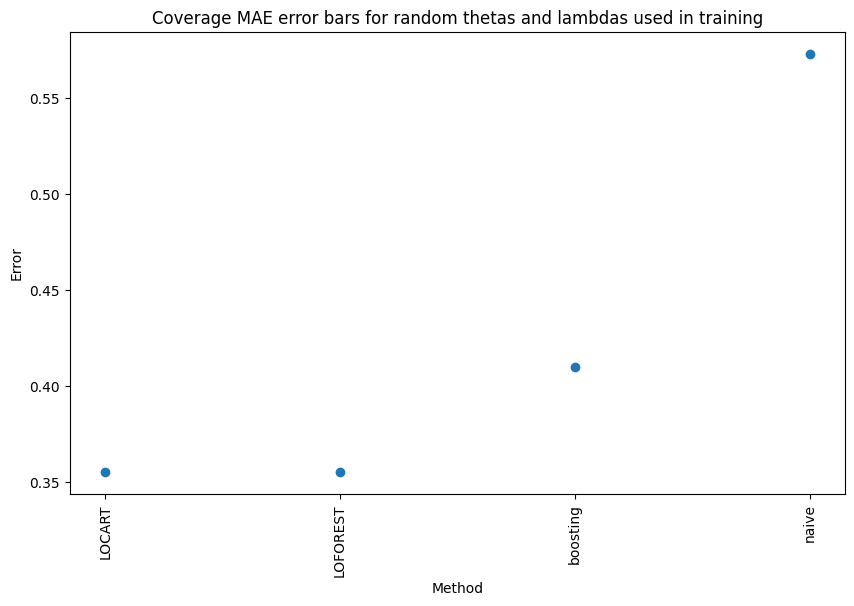

In [42]:
#| echo: false
keys = cover_data[0].iloc[:, 0].values
mae = cover_data[0].iloc[:, 1].values
std_err = cover_data[0].iloc[:, 2].values

plt.figure(figsize=(10, 6))
plt.errorbar(keys, mae, yerr=std_err, fmt='o')
plt.xlabel('Method')
plt.ylabel('Error')
plt.title('Coverage MAE error bars for random thetas and lambdas used in training')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()